In [1]:
import re
import ast
import itertools
from collections import Counter
import pandas as pd
import numpy as np
import scipy.sparse as sparse

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

from IPython.display import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
itemIndex = 'ItemIndex'
userIndex = 'UserIndex'
rating = 'overall'
binary = 'Binary'
keyPhrase = 'keyVector'
dataPath = 'data/baby/'
dataName = 'Data.csv'
KeyPhraseName = 'KeyPhrases.csv'
embedding_dims = 50

In [3]:
df = pd.read_csv(dataPath+dataName)
df.head()

,Unnamed: 0,overall,unixReviewTime,vector,keyVector,UserIndex,ItemIndex,Binary
0,0,5,1373932800,"[152, 9, 204, 586, 19, 106, 185, 3, 127, 1924,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2496,0,1
1,1,5,1372464000,"[8, 834, 7, 451, 6, 572, 1189, 5, 50, 111, 18,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1343,0,1
2,2,5,1395187200,"[539, 80, 205, 619, 119, 12, 233, 212, 50, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8234,0,1
3,3,5,1376697600,"[4, 87, 8, 6, 157, 243, 9, 12, 352, 75, 2, 17,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15045,0,1
4,4,4,1396310400,"[4, 284, 85, 1524, 3, 7983, 39, 919, 7886, 612...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5810,0,1


In [4]:
num_user = df[userIndex].nunique()
num_item = df[itemIndex].nunique()
num_keyPhrases = len(ast.literal_eval(df[keyPhrase][0]))
print("Number of User: {0}".format(num_user))
print("Number of Item: {0}".format(num_item))
print("Number of key Phrase: {0}".format(num_keyPhrases))

Number of User: 19445
Number of Item: 7050
Number of key Phrase: 50


In [5]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [6]:
def getArrays(df):
    users = df[userIndex].as_matrix()
    items = df[itemIndex].as_matrix()
    ratings = df[rating].as_matrix()
    keys = np.array(df[keyPhrase].apply(ast.literal_eval).values.tolist())
    return [users,items,ratings,keys]

train_array = getArrays(train_df)
test_array = getArrays(test_df)

## Negative Sampling
Use negative sampling only when implicit feedback!

In [7]:
# def negative_data(df, size_per_user):

#     m = df[userIndex].nunique()
#     n = df[itemIndex].nunique()
    
#     users = []
#     items = []

#     negative_data = []
#     for i in range(m):
#         sampled_items = np.random.choice(n, size_per_user, replace=False)
#         observed_items = df[df[userIndex] == i][itemIndex].as_matrix().flatten()
#         sampled_items = sampled_items[np.invert(np.isin(sampled_items, observed_items))]
#         users += [i]*len(sampled_items)
#         items += sampled_items.tolist()
        
#     ratings = [0]*len(users)
#     keys = np.zeros([len(users), num_keyPhrases])

#     return [np.array(users),np.array(items),np.array(ratings),keys]
# negative_data = negative_data(train_df, 100)

In [8]:
# def concateData(positive, negative):
#     users = np.concatenate([positive[0], negative[0]])
#     items = np.concatenate([positive[1], negative[1]])
#     ratings = np.concatenate([positive[2], negative[2]])
#     keys = np.concatenate([positive[3], negative[3]])
#     return [np.array(users),np.array(items),np.array(ratings),keys]

# train_array = concateData(train_array, negative_data)

## Model

In [9]:
from keras.models import Model
from keras.layers import *   
from keras.backend import reshape

In [10]:
def build_model():
    userIndex = Input(shape=(1,), name='userIndex')
    itemIndex = Input(shape=(1,), name='itemIndex')

    userEmbedding = Embedding(num_user, embedding_dims, name='userEmbedding')(userIndex)
    itemEmbedding = Embedding(num_item, embedding_dims, name='itemEmbedding')(itemIndex)

    merged = concatenate([userEmbedding, itemEmbedding])
    x = Flatten()(merged)
    x = BatchNormalization()(x)
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    hidden = BatchNormalization()(x)
    pred_rating= Dense(1, activation='linear', name='rating')(hidden)
    pred_keyPhrase= Dense(num_keyPhrases, activation='sigmoid', name='keyPhrase')(hidden)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=[userIndex, itemIndex], outputs=[pred_rating, pred_keyPhrase])
    model.compile(optimizer='rmsprop',
                  loss=["mean_squared_error", "mean_squared_error"],
                  loss_weights = [1.3,1],
                  metrics=['accuracy'])

    return model

model = build_model()

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
userIndex (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
itemIndex (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
userEmbedding (Embedding)       (None, 1, 50)        972250      userIndex[0][0]                  
__________________________________________________________________________________________________
itemEmbedding (Embedding)       (None, 1, 50)        352500      itemIndex[0][0]                  
__________________________________________________________________________________________________
concatenat

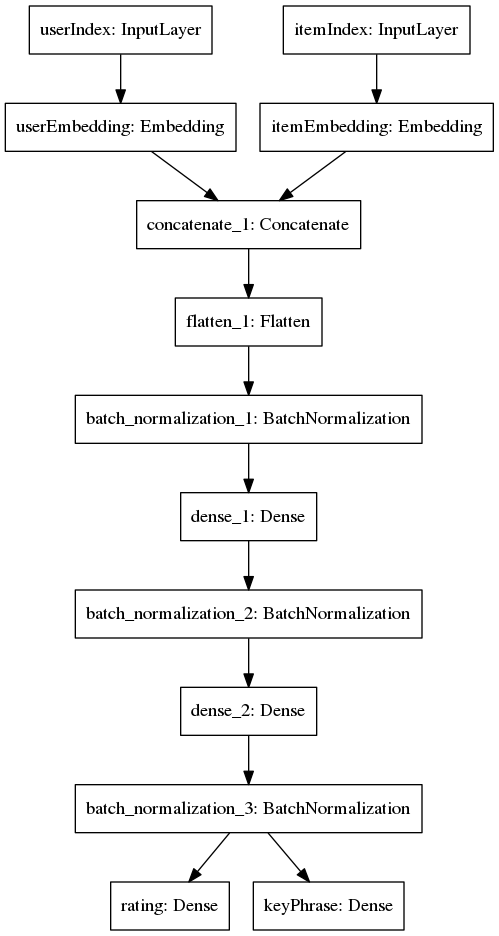

In [12]:
plot_model(model, to_file='multiple_outputs.png')
Image(filename='multiple_outputs.png') 

In [13]:
history = model.fit(train_array[:2], train_array[2:], 
                    validation_data=(test_array[:2], test_array[2:]), epochs=10, batch_size=32)

Train on 144773 samples, validate on 16019 samples
Epoch 1/10
144773/144773 [==============================] - 48s 334us/step - loss: 17.8670 - rating_loss: 1.7857 - keyPhrase_loss: 0.0096 - rating_acc: 0.2859 - keyPhrase_acc: 0.0064 - val_loss: 12.9539 - val_rating_loss: 1.2953 - val_keyPhrase_loss: 0.0012 - val_rating_acc: 0.3329 - val_keyPhrase_acc: 0.0054
Epoch 2/10
144773/144773 [==============================] - 48s 330us/step - loss: 12.0398 - rating_loss: 1.2039 - keyPhrase_loss: 0.0013 - rating_acc: 0.3406 - keyPhrase_acc: 0.0060 - val_loss: 12.3624 - val_rating_loss: 1.2361 - val_keyPhrase_loss: 0.0012 - val_rating_acc: 0.3830 - val_keyPhrase_acc: 0.0054
Epoch 3/10
144773/144773 [==============================] - 48s 329us/step - loss: 10.5424 - rating_loss: 1.0541 - keyPhrase_loss: 0.0013 - rating_acc: 0.4204 - keyPhrase_acc: 0.0061 - val_loss: 12.2491 - val_rating_loss: 1.2248 - val_keyPhrase_loss: 0.0012 - val_rating_acc: 0.3346 - val_keyPhrase_acc: 0.0054
Epoch 4/10
14477

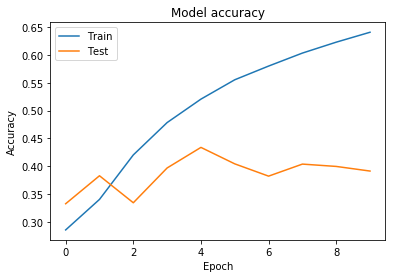

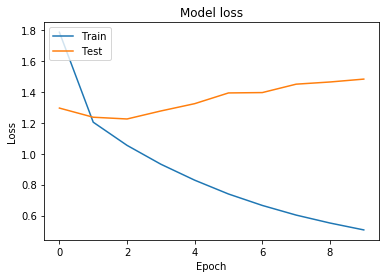

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['rating_acc'])
plt.plot(history.history['val_rating_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['rating_loss'])
plt.plot(history.history['val_rating_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

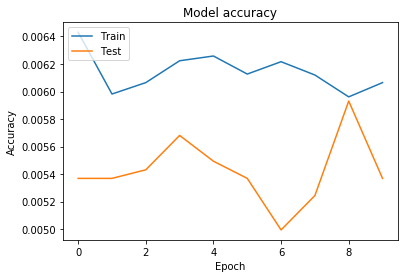

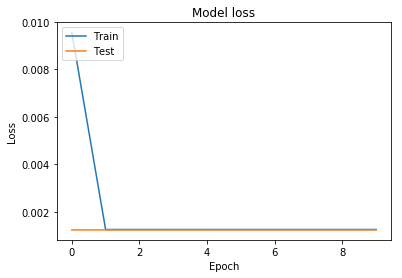

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['keyPhrase_acc'])
plt.plot(history.history['val_keyPhrase_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['keyPhrase_loss'])
plt.plot(history.history['val_keyPhrase_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
prediction = model.predict(test_array[:2])

In [17]:
prediction

[array([[4.579327 ],
        [4.720199 ],
        [4.48505  ],
        ...,
        [4.6834364],
        [4.757323 ],
        [3.5493033]], dtype=float32),
 array([[1.6082287e-05, 5.2281566e-06, 1.6599020e-05, ..., 6.1865380e-06,
         4.1535892e-05, 6.8693400e-05],
        [3.4328968e-05, 1.0606703e-05, 4.1878819e-05, ..., 1.1241272e-05,
         1.4430651e-04, 2.1889913e-04],
        [5.9928147e-06, 2.7363296e-06, 7.1359841e-06, ..., 2.7724791e-06,
         2.2472397e-05, 2.3977162e-05],
        ...,
        [5.6835952e-06, 2.6300074e-06, 6.9648795e-06, ..., 3.1208040e-06,
         2.6156220e-05, 3.1226944e-05],
        [3.3427352e-06, 8.2049655e-07, 2.3952502e-06, ..., 1.1081165e-06,
         7.9729680e-06, 2.3846498e-05],
        [1.1471633e-05, 7.4878435e-06, 1.2906067e-05, ..., 6.7601932e-06,
         3.7841692e-05, 3.3934022e-05]], dtype=float32)]

In [18]:
def PredictTopK(model, topK_item, topK_keyPhrase, keyPhrase):
    
    explain_dicts = []
    for i in tqdm(range(5)):
        inputs = [np.array([i]*num_item), np.arange(num_item)]
        predictions = model.predict(inputs)
        index_topK = np.argsort(predictions[0].flatten())[::-1][:topK_item]
        for j in index_topK:
            explain = keyPhrase[np.argsort(predictions[1][j].flatten())[::-1][:topK_keyPhrase]]
            explain_dicts.append({'UserIndex': i, 'ItemIndex': j, 'Explanation': explain})
            
    return pd.DataFrame(explain_dicts)

In [19]:
df = pd.read_csv(dataPath+KeyPhraseName)
keyPhrase = np.array(df['Phrases'].tolist())

In [20]:
df_explain = PredictTopK(model, 3, 3, keyPhrase)

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


In [21]:
df_explain

,Explanation,ItemIndex,UserIndex
0,"[customer service, gender neutral, skip hop]",2455,0
1,"[customer service, gender neutral, nail clipper]",4539,0
2,"[customer service, gender neutral, skip hop]",5861,0
3,"[customer service, gender neutral, skip hop]",1391,1
4,"[customer service, gender neutral, skip hop]",6092,1
5,"[customer service, gender neutral, skip hop]",748,1
6,"[thank goodness, gender neutral, peg perego]",4551,2
7,"[thank goodness, peg perego, oxo tot]",6140,2
8,"[aden +, thank goodness, + anais]",1208,2
9,"[aden +, choking hazard, peg perego]",5002,3


# Problem
it seems key word selected from data processing has problem. Those keys phrases are too sparse and also not very informative. Should think better idea to extract key phrases.